# Unsuccessful examples of using Dynamic mode decomposition on PDE system 


We apply dynamic mode decomposition (DMD) to several PDE systems. Some of them are from J. Nathan Kutz,
J. L. Proctor, and S. L. Brunton,
“Applied Koopman Theory for Partial Differential Equations and Data-Driven
Modeling of Spatio-Temporal Systems,” Complexity, vol. 2018, no. ii, pp. 1–16, 2018.): 1) 1D cubic-quintic Ginzburg-Landau equation 2) 1D Kuramoto-Sivashinsky equation (chaotic regime)

Note: In these two examples, DMD does not work well because 
1. the system is chaotic and there is no dominating low-rank linear structure, i.e., growing or decaying harmonics.
2. the system contains a transient phase to the attractor, where (vanilla) DMD can easily fail to capture with stable eigenvalues. 

We first import the pyKoopman package and other packages for plotting and matrix manipulation.

In [1]:
import sys
sys.path.append('../src')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import pykoopman as pk

Define plotting function

In [3]:
def plot_pde_dynamics(x, t, X, X_pred, title_list, ymin=0, ymax=1):
    
    fig = plt.figure(figsize=(12, 8))
    
    ax = fig.add_subplot(131, projection='3d')
    for i in range(X.shape[0]):
        if X.dtype != 'complex':
            ax.plot(x, X[i], zs=t[i], zdir='t')
        else:
            ax.plot(x, abs(X[i]), zs=t[i], zdir='t')     
    ax.set_ylim([ymin, ymax])
    ax.view_init(elev=35., azim=-65, vertical_axis='y')
    if X.dtype != 'complex':
        ax.set(ylabel=r'$u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    else:
        ax.set(ylabel=r'mag. of $u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
        
    plt.title(title_list[0])

    ax = fig.add_subplot(132, projection='3d')
    for i in range(X.shape[0]):
        if X.dtype != 'complex':
            ax.plot(x, X_pred[i], zs=t[i], zdir='t')
        else:
            ax.plot(x, abs(X_pred[i]), zs=t[i], zdir='t')
    ax.set_ylim([ymin, ymax])
    ax.view_init(elev=35., azim=-65, vertical_axis='y')
    if X.dtype != 'complex':
        ax.set(ylabel=r'$u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    else:
        ax.set(ylabel=r'mag. of $u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    plt.title(title_list[1])
    
    ax = fig.add_subplot(133, projection='3d')
    for i in range(X.shape[0]):
        if X.dtype != 'complex':
            ax.plot(x, X_pred[i]-X[i], zs=t[i], zdir='t')
        else:
            ax.plot(x, abs(X_pred[i]-X[i]), zs=t[i], zdir='t')
    ax.set_ylim([ymin, ymax])
    ax.view_init(elev=35., azim=-65, vertical_axis='y')
    if X.dtype != 'complex':
        ax.set(ylabel=r'$u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    else:
        ax.set(ylabel=r'mag. of $u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    plt.title(title_list[2])

## 1. cubic-quintic Ginzburg-Landau equation

$$
    iu_t + (0.5 - i\tau) u_{xx} - i\kappa u_{xxxx} + (1-i\beta)|u|^2 u +
    (\nu - i\sigma)|u|^4 u - i \gamma u = 0
$$

periodic boundary condition in $[-10,10]$ with initial condition as 
$\exp(-x^2)$. We collect 300 snapshots from $t\in [0,40]$. 

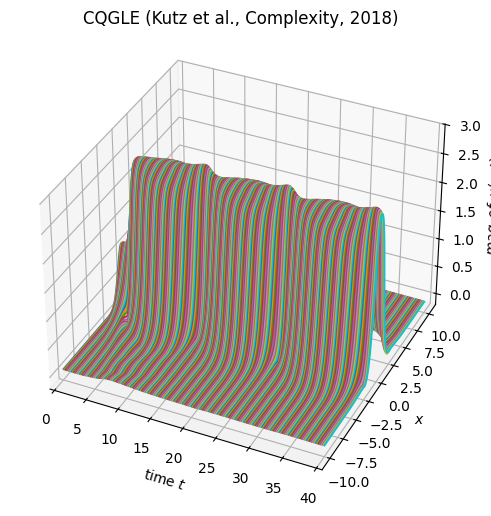

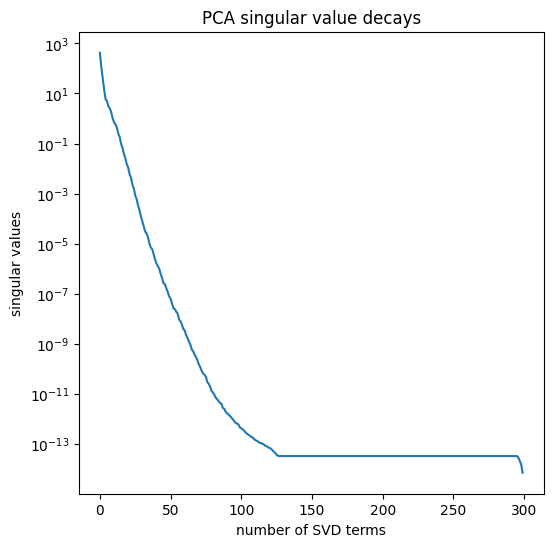

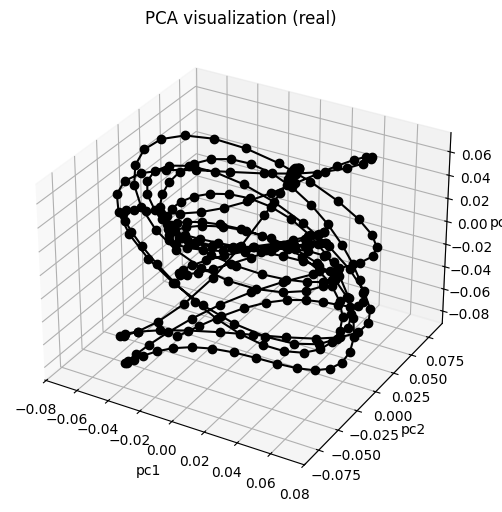

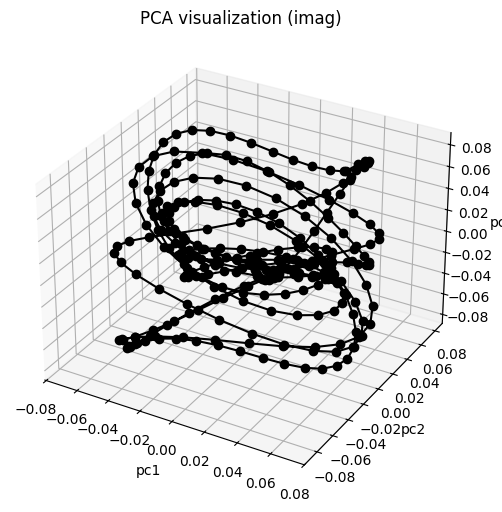

In [4]:
from pykoopman.common import cqgle

n = 512
x = np.linspace(-10, 10, n, endpoint=False)
u0 = np.exp(-((x) ** 2))
# u0 = 2.0 / np.cosh(x)
# u0 = u0.reshape(-1,1)
n_int = 9000
n_snapshot = 300
dt = 40.0 / n_int
n_sample = n_int // n_snapshot

model_cqgle = cqgle(n, x, dt, L=20)
X, t = model_cqgle.simulate(u0, n_int, n_sample)

delta_t = t[1] - t[0]

# usage: visualize the data in physical space
model_cqgle.visualize_data(x, t, X)
model_cqgle.visualize_state_space(X)

run a vanilla DMD with rank = 50

In [5]:
from pydmd import DMD

dmd = DMD(svd_rank=50)
model = pk.Koopman(regressor=dmd)
model.fit(X, dt=delta_t)

Koopman(observables=Identity(),
        regressor=PyDMDRegressor(regressor=<pydmd.dmd.DMD object at 0x0000013B43F96390>))

Text(0, 0.5, '$Im(\\lambda)$')

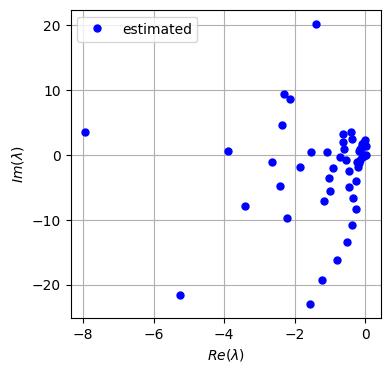

In [6]:
K = model.A

# Let's have a look at the eigenvalues of the Koopman matrix
evals, evecs = np.linalg.eig(K)
evals_cont = np.log(evals)/delta_t

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
# ax.plot(evals.real, evals.imag, 'bo', label='estimated', markersize=5)
ax.plot(evals_cont.real, evals_cont.imag, 'bo', label='estimated', markersize=5)
plt.legend()
plt.grid('on')
plt.xlabel(r'$Re(\lambda)$')
plt.ylabel(r'$Im(\lambda)$')

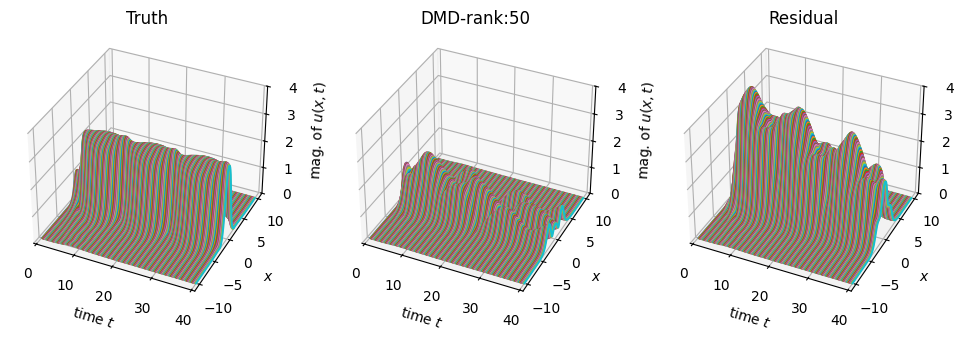

In [7]:
X_predicted = np.vstack((X[0], model.simulate(X[0], n_steps=X.shape[0]-1)))
plot_pde_dynamics(x, t, X, X_predicted, 
                  ['Truth','DMD-rank:'+str(model.A.shape[0]),'Residual'], 0, 4)

## 2. K-S equation

$$
    u_t + u u_{x} = u_{xx} + \nu u_{xxxx}
$$
where $\nu=0.01$, periodic boundary condition in $[0,2\pi]$ with initial condition as 
$\sin(x)$. We collect 500 snapshots from $t\in [0,4]$. 

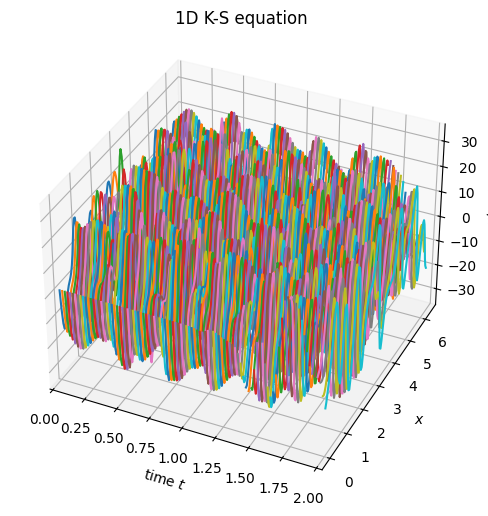

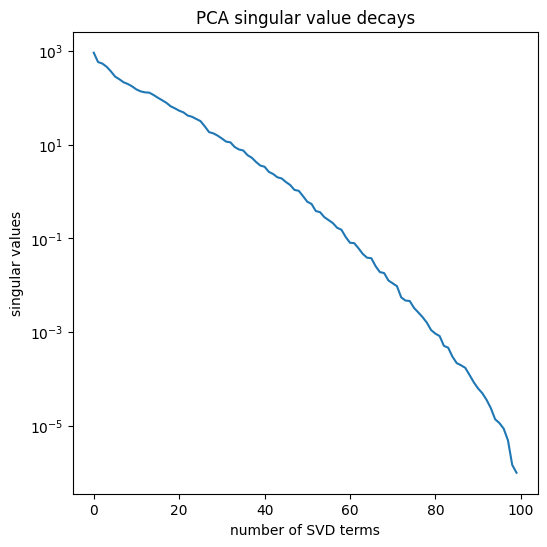

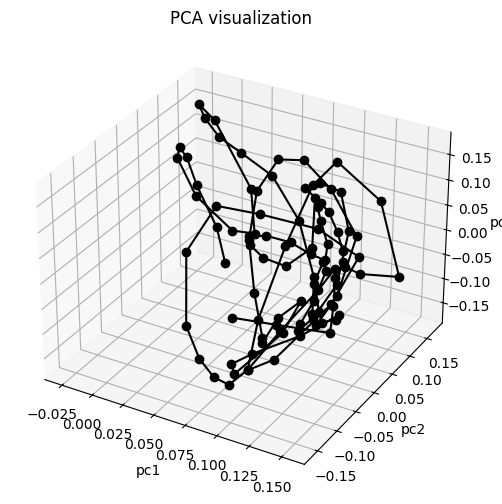

In [8]:
from pykoopman.common import ks

n = 128
x = np.linspace(0, 2.0 * np.pi, n, endpoint=False)
u0 = np.sin(x)
nu = 0.01
n_int = 1000
n_snapshot = 200
dt = 4.0 / n_int
n_sample = n_int // n_snapshot

model_ks = ks(n, x, nu=nu, dt=dt)
X, t = model_ks.simulate(u0, n_int, n_sample)

# select X after on the chaotic attractor
X = X[n_snapshot//2:,:]

model_ks.visualize_data(x, t, X)

# usage: visualize the data in state space
model_ks.visualize_state_space(X)

run a vanilla DMD with rank = 64

In [9]:
from pydmd import DMD

dmd = DMD(svd_rank=24)
model = pk.Koopman(regressor=dmd)
model.fit(X, dt=delta_t)

Koopman(observables=Identity(),
        regressor=PyDMDRegressor(regressor=<pydmd.dmd.DMD object at 0x0000013B3FF2B9D0>))

Text(0, 0.5, '$Im(\\lambda)$')

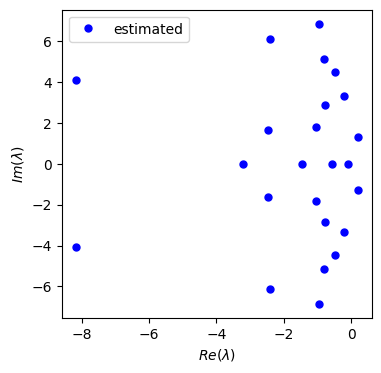

In [10]:
K = model.A

# Let's have a look at the eigenvalues of the Koopman matrix
evals, evecs = np.linalg.eig(K)
evals_cont = np.log(evals)/delta_t

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(evals_cont.real, evals_cont.imag, 'bo', label='estimated', markersize=5)
plt.legend()
plt.xlabel(r'$Re(\lambda)$')
plt.ylabel(r'$Im(\lambda)$')

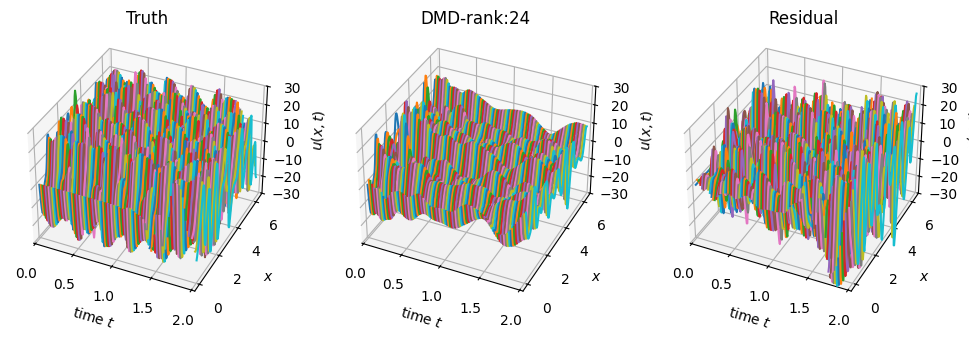

In [11]:
X_predicted = np.vstack((X[0], model.simulate(X[0], n_steps=X.shape[0]-1)))
plot_pde_dynamics(x, t, X, X_predicted, 
                  ['Truth','DMD-rank:'+str(model.A.shape[0]),'Residual'], 
                  -30, 30)

**Conclusion:**
- DMD didn't work well for **long time prediction of chaotic system**.